In [26]:
!pip install -q opencv-python

In [97]:
import numpy as np
import pandas as pd
import pickle as pkl
import os 
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision.models import resnet50
import torch.nn as nn
from tqdm import tqdm
from torchvision import transforms
from sklearn.neighbors import NearestNeighbors
from PIL import Image, ImageTk
import tkinter as tk

In [ ]:
base  = './data/data'

In [58]:
filenames = []
for root, dirs, files in os.walk(base):
    for file in files:
        filenames.append(os.path.join(root, file))

In [59]:
len(filenames)

18175

In [60]:
filenames[:10]

['./data/data\\BABY_PRODUCTS\\1000_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1001_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1002_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1003_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1004_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1005_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1006_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1007_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1008_BABY_P_train.jpeg',
 './data/data\\BABY_PRODUCTS\\1009_BABY_P_train.jpeg']

In [11]:
categories_name = os.listdir()

In [12]:
categories_name

['BABY_PRODUCTS',
 'BEAUTY_HEALTH',
 'CLOTHING',
 'ELECTRONICS',
 'GROCERY',
 'HOBBY_ARTS_STATIONERY',
 'HOME_KITCHEN_TOOLS',
 'PET_SUPPLIES',
 'SPORTS_OUTDOOR']

In [16]:
## images in each category
count = {}

for root, dirs, files in os.walk(base):
    for d in dirs:
        count[d] = len(os.listdir(os.path.join(base, d)))

In [17]:
count

{'BABY_PRODUCTS': 1412,
 'BEAUTY_HEALTH': 1562,
 'CLOTHING': 1391,
 'ELECTRONICS': 1757,
 'GROCERY': 5166,
 'HOBBY_ARTS_STATIONERY': 1417,
 'HOME_KITCHEN_TOOLS': 2228,
 'PET_SUPPLIES': 1637,
 'SPORTS_OUTDOOR': 1605}

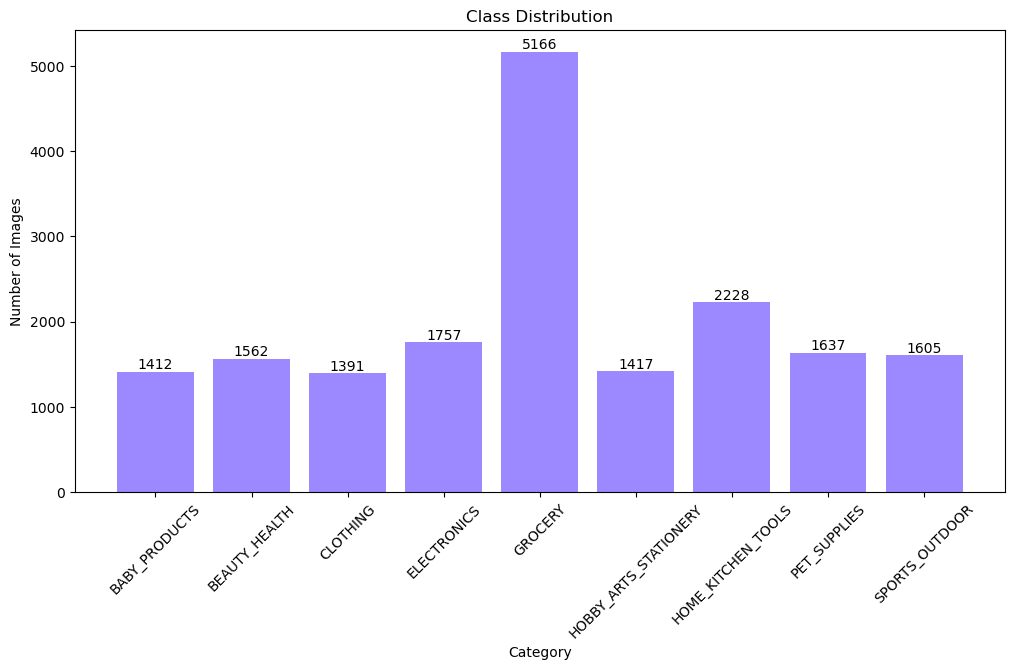

In [20]:
plt.figure(figsize=(12, 6))
bars = plt.bar(count.keys(), count.values(), color='#9c88ff')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


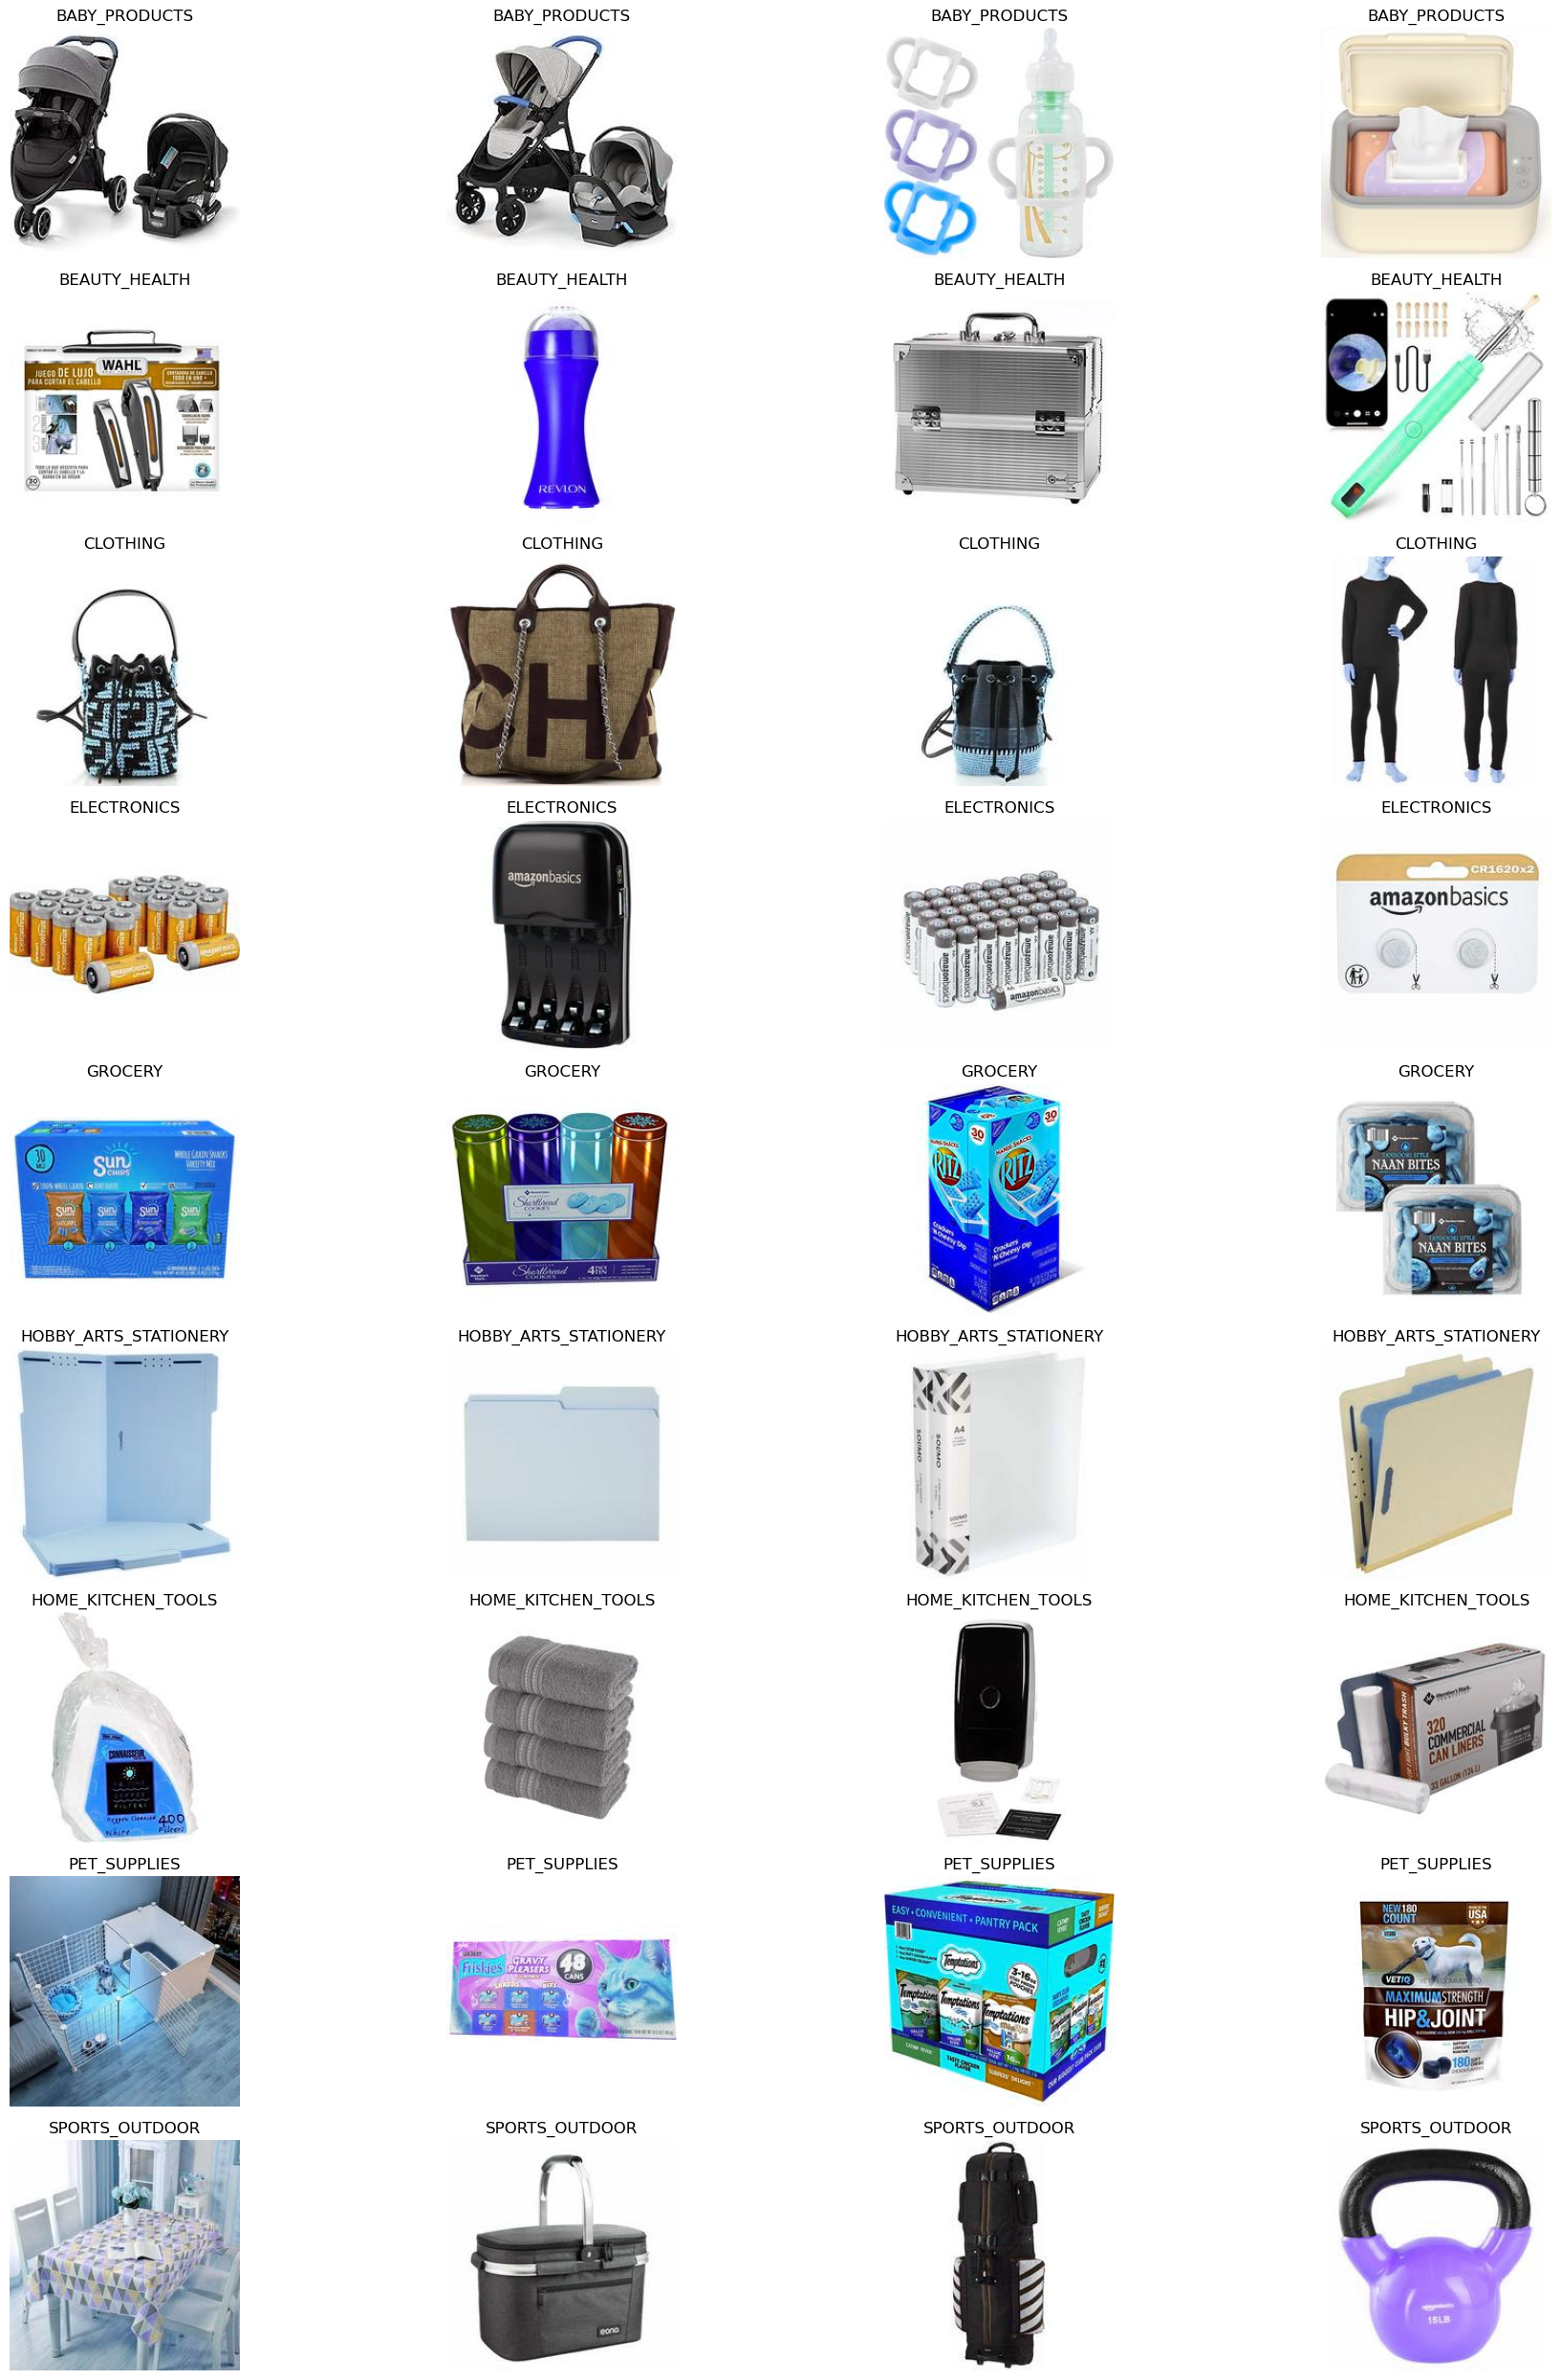

In [31]:
index = 0

fig, axes = plt.subplots(9, 4, figsize=(20, 25))  
axes = axes.flatten() 
for root, dir, files in os.walk(base):
     for i in dir:
        file_list = os.listdir(os.path.join(root, i))
        f = file_list[0:4]
        for fi in f:
            img_path = os.path.join(root, i, fi)
            img = cv2.imread(img_path)
            print(img.shape)
            axes[index].set_title(i)         
            axes[index].imshow(img)
            axes[index].axis('off')
            index += 1

plt.tight_layout()
plt.show()

In [45]:
resnet = resnet50(pretrained=True)
for param in resnet.parameters():
    param.required_grad = False

## FC (fully connected layer) cls head
## second-to-last layer (before classification)
model = nn.Sequential(*list(resnet.children())[:-1])

C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Dell/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:48<00:00, 942kB/s]


In [46]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for ResNet
])

In [61]:
def extract_features(img_path, model):
    ## load the image
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0) # adding batch dim
    model.eval()
    with torch.no_grad():
        features = model(img_tensor)
        
    ## flatten the output (since ResNet gives a 4D tensor output)
    features = features.view(features.size(0), -1)
    norm_results = features / torch.norm(features, p=2, dim=1, keepdim=True) ## L2 normalization
    
    return norm_results.numpy().flatten()

In [62]:
img_features = []
for file in tqdm(filenames):
    img_features.append(extract_features(file, model))

100%|███████████████████████████████████████████████████████████████████| 18175/18175 [47:52<00:00,  6.33it/s]


In [67]:
pkl.dump(img_features, open('Images_features.pkl', 'wb'))
pkl.dump(filenames, open('filenames.pkl', 'wb'))

In [90]:
with open('Images_features.pkl', 'rb') as f:
    features = pickle.load(f)

In [91]:
with open('filenames.pkl', 'rb') as i:
    images = pickle.load(i)

In [92]:
assert len(images) == len(features), "Mismatch between the number of images and features"

In [93]:
i = np.vstack(features)
n_neighbors = min(5, len(features))
nn_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean')
nn_model.fit(i)

NearestNeighbors(algorithm='brute', metric='euclidean')

In [94]:
distances, indices = nn_model.kneighbors(i[0].reshape(1, -1))

In [96]:
nip = [images[idx[0]] for idx in indices]  # Use the indices to get the image paths

print(f"Indices of Nearest Neighbors: {indices}")
print(f"Distances to Nearest Neighbors: {distances}")
print(f"Paths of Nearest Neighbors: {nip}")

Indices of Nearest Neighbors: [[   0 1387 1367 1346 1326]]
Distances to Nearest Neighbors: [[0.         0.13343698 0.16820921 0.18919341 0.19348684]]
Paths of Nearest Neighbors: ['./data/data\\BABY_PRODUCTS\\1000_BABY_P_train.jpeg']


In [110]:
def get_recommendation(img_path, model, neighbors, filenames):
    input_img = extract_features(img_path, model)
    distances, indices = nn_model.kneighbors([input_img])
    root = tk.Tk()
    root.title("Image Recommendations")
    image_labels = []  

    for idx in indices[0]:
        recommended_image = filenames[idx]
        img = cv2.imread(recommended_image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img = img.resize((200, 200))  # Resize the image to fit the window
        img_tk = ImageTk.PhotoImage(img)


        label = tk.Label(root, image=img_tk)
        label.image = img_tk
        label.pack(side="left", padx=5, pady=5)
        image_labels.append(label)


    root.mainloop()
    

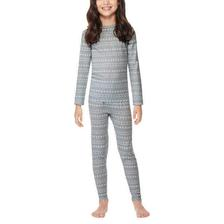

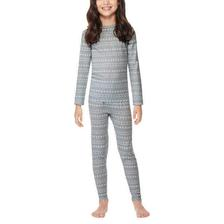

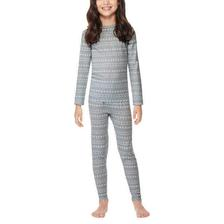

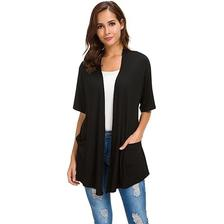

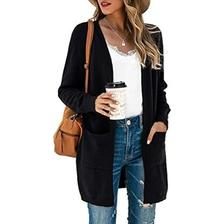

In [114]:
from IPython.display import Image as IPImage, display

def get_recommendation(img_path, model, nn_model, filenames):
    input_img = extract_features(img_path, model)
    distances, indices = nn_model.kneighbors([input_img])

    # Display images within the notebook
    for idx in indices[0]:
        recommended_image = images[idx]
        display(IPImage(filename=recommended_image))  # Display image inline

# Call the function
get_recommendation('images.jpg', model, nn_model, images)

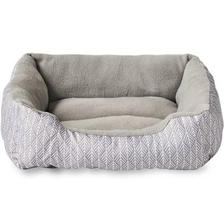

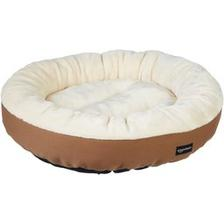

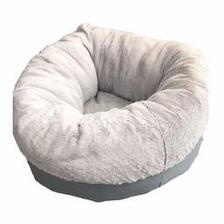

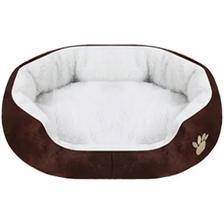

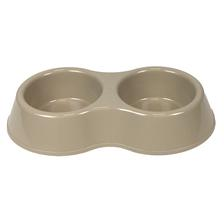

In [116]:
get_recommendation('pet2.jpg', model, nn_model, images)